In [1]:
import os
import random
import copy
import torchvision
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset_class import FaceMaskDataset

# Import dataset

In [2]:
def visualize_dataset(dataset):
    for i in random.sample(range(0, len(face_mask_dataset)), 5):
        image, label = face_mask_dataset[i]

        print(f'Image number: {i}')
        print(f'Image shape: {image.shape}')
        print(f'Label: {label}')

        fig =  plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.show()

In [3]:
transform_to_tensor = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                      torchvision.transforms.ToTensor(),
                                                      torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
face_mask_dataset = FaceMaskDataset(root_dir='dataset', transform=transform_to_tensor)

# visualize_dataset(face_mask_dataset)

# Train/test split dataset

In [4]:
dataset_indices = list(range(len(face_mask_dataset)))

random.shuffle(dataset_indices)
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.8)]  
valid_split_indices = dataset_indices[int(len(dataset_indices)*0.8):] 

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
batch_size = 32
num_workers = 8

train_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=valid_subset_sampler, num_workers=num_workers)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(train_subset_sampler), 'val': len(valid_subset_sampler)}

## Check if GPU is available

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define and train classification model

In [6]:
def plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, epochs, name=None):
    plt.style.use("ggplot")
    plt.figure()
    
    plt.plot(np.arange(0, epochs), train_loss, label="train_loss")
    plt.plot(np.arange(0, epochs), val_loss, label="val_loss")
    plt.plot(np.arange(0, epochs), train_accuracy, label="train_acc")
    plt.plot(np.arange(0, epochs), val_accuracy, label="val_acc")
    
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    if name != None:
        plt.savefig(name + '.png')

In [7]:
def train_model(model, criterion, optimizer, num_epochs):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[mode]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training mode
                    if mode == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[mode]
            epoch_acc = float(running_corrects) / dataset_sizes[mode]
            
            if mode == 'train':
                train_accuracy.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)

            print(f'{mode} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if mode == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {(time_elapsed // 60):.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')
    
    name = input('Enter image file name:')
    plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, num_epochs, name)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
--------------------------------------------------
train Loss: 0.1515 Acc: 0.9385
val Loss: 0.0499 Acc: 0.9845

Epoch 1/19
--------------------------------------------------
train Loss: 0.0986 Acc: 0.9608
val Loss: 0.0679 Acc: 0.9746

Epoch 2/19
--------------------------------------------------
train Loss: 0.0717 Acc: 0.9749
val Loss: 0.0747 Acc: 0.9779

Epoch 3/19
--------------------------------------------------
train Loss: 0.0697 Acc: 0.9752
val Loss: 0.0366 Acc: 0.9901

Epoch 4/19
--------------------------------------------------
train Loss: 0.0673 Acc: 0.9724
val Loss: 0.0511 Acc: 0.9845

Epoch 5/19
--------------------------------------------------
train Loss: 0.0615 Acc: 0.9774
val Loss: 0.0839 Acc: 0.9724

Epoch 6/19
--------------------------------------------------
train Loss: 0.0679 Acc: 0.9741
val Loss: 0.0366 Acc: 0.9890

Epoch 7/19
--------------------------------------------------
train Loss: 0.0390 Acc: 0.9862
val Loss: 0.0334 Acc: 0.9923

Epoch 8/19
-----

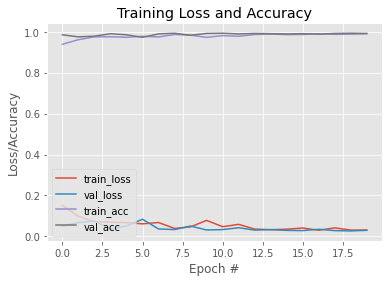

In [16]:
model_name = 'mobilenet_v2' # can be 'resnet50' and 'inception_v3' and 'mobilenet_v2'

if model_name == 'resnet50':
    model = torchvision.models.resnet50(pretrained=True)
elif model_name == 'inception_v3':
    model = torchvision.models.inception_v3(pretrained=True)
    model.aux_logits=False
elif model_name == 'mobilenet_v2':
    model = torchvision.models.mobilenet_v2(pretrained=True)
 
# do not update pretrained weights
for param in model.parameters():
    param.requires_grad = False
    
finetuned_model = copy.deepcopy(model)

if model_name == 'mobilenet_v2':
    finetuned_model.classifier = nn.Sequential(nn.Linear(finetuned_model.last_channel, 256),
                                               nn.ReLU(),
                                               nn.Dropout(0.5),
                                               nn.Linear(256, 2),
                                               nn.LogSoftmax(dim=1))
else:
    num_ftrs = finetuned_model.fc.in_features
    finetuned_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256, bias=True),
                                       nn.ReLU(),
                                       nn.Dropout(0.4),
                                       nn.Linear(256, 2),
                                       nn.LogSoftmax(dim=1))

finetuned_model = finetuned_model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()))

num_epochs = 20

# change num_epochs to smaller number for faster iteration
best_model = train_model(finetuned_model, criterion, optimizer, num_epochs)  

In [17]:
torch.save(best_model, 'models/mobilenet_LRDL_80_20_epochs20_acc0992274.pt')
# best_model = torch.load('models/resnet50_LRDL_80_20_epochs20_acc0991170.pt')
# print(best_model)

# Visualize model output

In [18]:
def visualize_model(model, num_images=20):
    model.eval()
    model = model.to(device)
    
    images_so_far = 0
    fig = plt.figure(figsize=(30, 30))
    
    params = {'text.color': 'red', 'font.size': 15}
    plt.rcParams.update(params)

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            tmp, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(face_mask_dataset.class_names[preds[i]]))
                
                img = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  

                plt.imshow(img)

                if images_so_far == num_images:
                    return
            
            plt.show()
            
            
# visualize_model(best_model)

# Evaluate model

0it [00:00, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


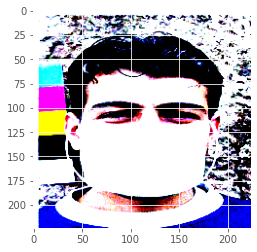

1it [00:00,  1.90it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


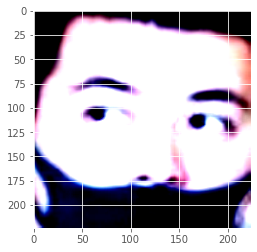

9it [00:01,  6.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


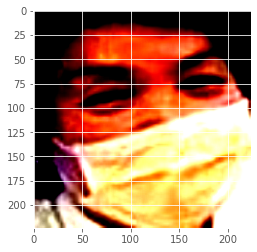

11it [00:01,  6.17it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


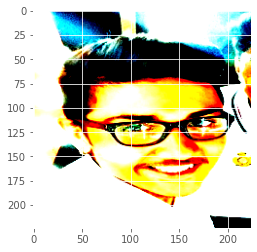

20it [00:02,  8.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


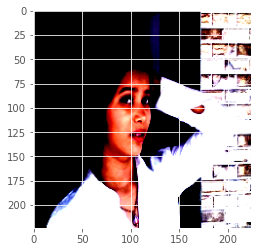

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


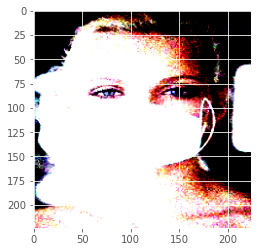

24it [00:03,  7.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


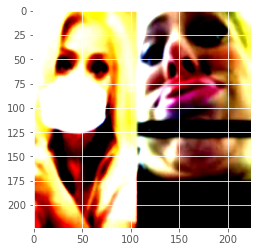

29it [00:04,  6.80it/s]


Evaluate model on training set


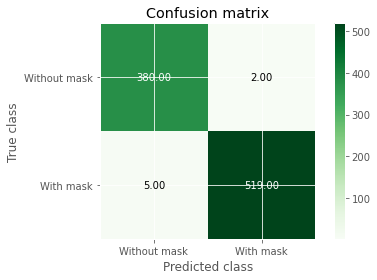

Accuracy: 0.9922737306843267
Precision(with mask): 0.9961612284069098
Recall(with mask): 0.9904580152671756
F1: 0.9933014354066986


In [20]:
from evaluation import evaluate_model

best_model.cuda()
best_model.eval()

all_val_labels = torch.empty(0).to(device)
all_val_pred = torch.empty(0).to(device)
all_probabilities = torch.empty(0).to(device)

plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in tqdm(enumerate(dataloaders['val'])):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)

        if i == 0: 
            all_probabilities = outputs
        else:
            all_probabilities = torch.cat((all_probabilities, outputs), 0)

        _, preds = torch.max(outputs, 1)
        
        # Uncomment next six lines to visualize errors
        differs = preds != labels
        for i in range(len(differs)):
            if differs[i]:
                plt.imshow(inputs[i].cpu().permute(1, 2, 0))
#                 plt.savefig('found_errors/val/error'+str(i)+'.png')
                plt.show()
        
        all_val_labels = torch.cat((all_val_labels.long(), labels.long()))
        all_val_pred = torch.cat((all_val_pred.long(), preds.long()))

evaluate_model(all_val_labels.cpu(), all_val_pred.cpu(), all_probabilities[1], 'Evaluate model on training set')

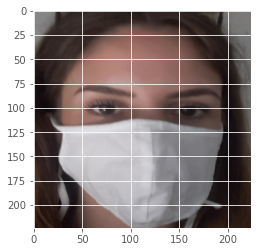

Predicted class: with_mask


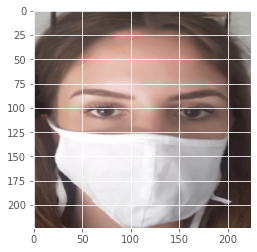

Predicted class: with_mask


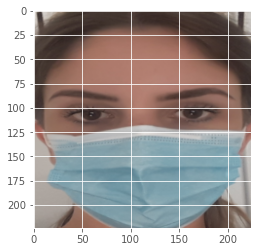

Predicted class: with_mask


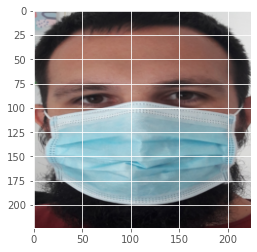

Predicted class: with_mask


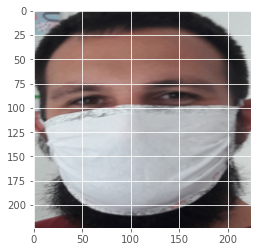

Predicted class: with_mask


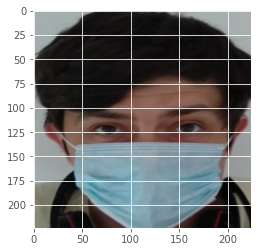

Predicted class: with_mask


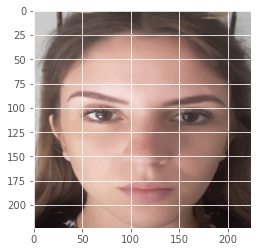

Predicted class: without_mask


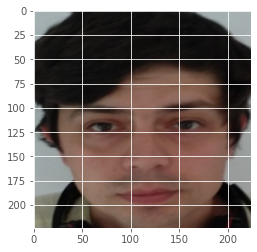

Predicted class: without_mask


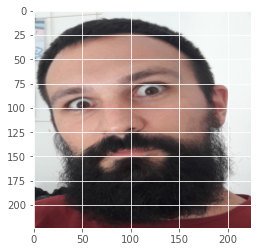

Predicted class: without_mask


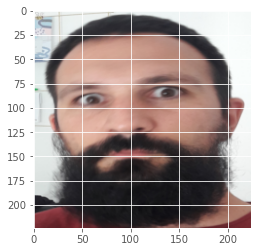

Predicted class: without_mask


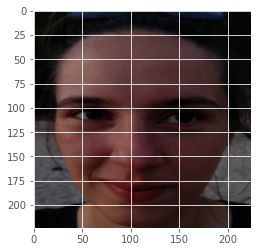

Predicted class: without_mask


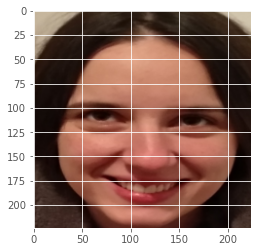

Predicted class: without_mask


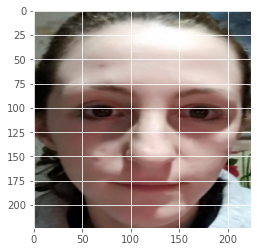

Predicted class: without_mask


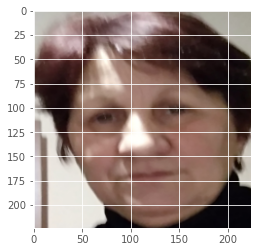

Predicted class: without_mask


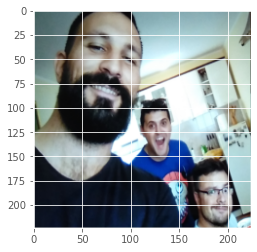

Predicted class: without_mask


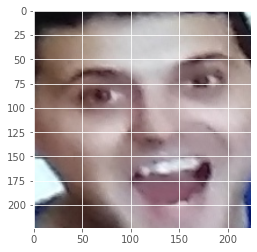

Predicted class: without_mask


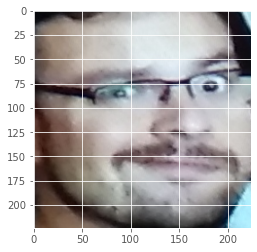

Predicted class: without_mask


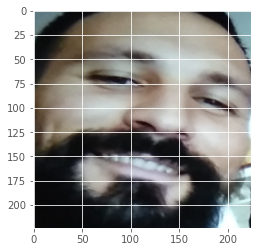

Predicted class: without_mask


In [21]:
from PIL import Image
from imutils import paths


best_model.cpu()
paths = list(paths.list_images('test_dataset'))
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

to_tensor = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                            torchvision.transforms.ToTensor()])

fig =  plt.figure()

for path in paths:
    image = Image.open(path).convert("RGB")
    img = transform(image)
    img = img.unsqueeze(0)

    output = best_model(img)
    _, predicted = torch.max(output, 1)
    
    plt.imshow(to_tensor(image).permute(1, 2, 0))
    plt.show()
    
    print(f'Predicted class: {face_mask_dataset.class_names[predicted[0]]}')